In [1]:
import sys
import os
import pandas as pd
import torch
import numpy as np
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as T
import random
from sklearn import preprocessing
from tqdm import tqdm
from PIL import Image
import cv2
from matplotlib import pyplot as plt
from sklearn import preprocessing
from torchsummary import summary
import PIL.Image as Image
import torchvision.transforms as transforms
sys.path.insert(0, './network')
sys.path.insert(0, './loss_func')
sys.path.insert(0,'./dataloader')
from facedata_loader import load_filenames_array
from facedata_loader import ThumbnailDataloader
from facedata_loader import NumpyDataloader
from facedata_loader import rescalor_class
from network_functions_ import discriminator_conv
from network_functions_ import decay_gauss_std
from network_functions_ import generator_upsample

In [2]:
#for this to work just download and unzip facedata and put folder in same directory as this main file
#link: https://github.com/NVlabs/ffhq-dataset
#go to and download thumbnails 128 x 128, rename as required and you are good to go
root_dir='./face_data/thumbnails/'
extension='.png'
thumbnails_locations = load_filenames_array(root_dir, extension)
thumbnails_locations = [location.replace('\\', '/')for location in thumbnails_locations]

In [3]:
thumbnails_locations[:5]

['./face_data/thumbnails/40000/40042.png',
 './face_data/thumbnails/40000/40243.png',
 './face_data/thumbnails/40000/40610.png',
 './face_data/thumbnails/40000/40281.png',
 './face_data/thumbnails/40000/40153.png']

In [4]:
thumbnails_location_df = pd.DataFrame(thumbnails_locations)
thumbnails_location_df.head()

,0
0,./face_data/thumbnails/40000/40042.png
1,./face_data/thumbnails/40000/40243.png
2,./face_data/thumbnails/40000/40610.png
3,./face_data/thumbnails/40000/40281.png
4,./face_data/thumbnails/40000/40153.png


In [5]:
thumbnails_location_df.iloc[0].values[0]

'./face_data/thumbnails/40000/40042.png'

In [6]:
rescalor_ = rescalor_class(-0.5, 0.5)
numpy_data_locations = []
#if numpy_data folder is not available in directory, just create a new folder and rename it as 'numpy_data' in same directory as this main file
root_npy = './numpy_data/'
#load image path into image, rescale and store in folder as numpy arrays
def image_to_numpy_data(thumbnails_locations_string_array, 
                        resize=(128, 128)):
    for idx, path_ in tqdm(enumerate(thumbnails_locations_string_array)):
        image_file = Image.open(path_)
        image_file = image_file.resize((resize[0], 
                        resize[1]), Image.ANTIALIAS)
        image_np = np.asarray(image_file)
        transposed_img = np.transpose(image_np, (2, 1, 0))
        #rescale
        transposed_img = np.expand_dims(transposed_img, axis=0)
        rescaled_image = rescalor_.rescale_image(transposed_img)#rescale data
        #print((rescaled_image).shape)
        np.save(root_npy+str(idx),np.squeeze(rescaled_image))
        #np.save(root_npy+str(idx),rescaled_image)
        numpy_data_locations.append(root_npy+str(idx)+'.npy')
image_to_numpy_data(thumbnails_locations)

65534it [07:43, 141.50it/s]


In [7]:
len(numpy_data_locations)

65534

In [8]:
np_location_df = pd.DataFrame(numpy_data_locations)
np_location_df

,0
0,./numpy_data/0.npy
1,./numpy_data/1.npy
2,./numpy_data/2.npy
3,./numpy_data/3.npy
4,./numpy_data/4.npy
...,...
65529,./numpy_data/65529.npy
65530,./numpy_data/65530.npy
65531,./numpy_data/65531.npy
65532,./numpy_data/65532.npy


In [9]:
#np_location_df.to_csv('np_data.csv', index=False)

In [2]:
np_location_df = pd.read_csv('np_data.csv')

In [3]:
#train_set = thumbnails_location_df.iloc[:60000,]
train_set = np_location_df.iloc[:60000,]

In [4]:
#load to a dataloader
train_loader = NumpyDataloader(train_set)#transform returning numpy to tensors

In [5]:
batch_size = 50
train_loader = DataLoader(train_loader, batch_size=batch_size,
                        shuffle=True, num_workers=0, drop_last=True)

In [6]:
#import network(s)
latent_size = 100

In [7]:
#if saved_networks folder is not available in directory, just create a new folder and rename it as 'saved_networks' in same directory as this main file
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def save_models(generator_network_model, discriminator_network_model):
    PATH = './saved_networks'
    torch.save(generator_network_model.state_dict(), os.path.join(PATH, "generator_model.pth"))
    torch.save(discriminator_network_model.state_dict(), os.path.join(PATH, "discriminator_model.pth"))
    
def load_models(generator_network_model, discriminator_network_model):
    PATH = './saved_networks'
    (generator_network_model.load_state_dict(torch.load(os.path.join(PATH, "generator_model.pth"),
                                                       map_location=device)))
    (discriminator_network_model.load_state_dict(torch.load(os.path.join(PATH, "discriminator_model.pth"),
                                                           map_location=device)))

In [8]:
epochs=500
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator_network_model = generator_upsample(latent_size,
                                            kernel_size_head = 2,
                                            stride_head = 2,
                                            hidden_channels=(1024, 512, 256, 128, 64, 32),
                                            upsample_body_factor = 2).to(device)



discriminator_network_model = discriminator_conv(hidden_channels = (3, 32, 64, 128, 256, 512, 1024),
                                                 stride = 2,
                                                 kernel_size = 4,
                                                 total_epochs = epochs).to(device)

c:\users\scowt\appdata\local\programs\python\python37\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [9]:
@torch.no_grad()
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)

In [10]:
#generator_network_model.apply(weights_init)
generator_network_model.apply(weights_init)

generator_upsample(
  (main_head): Sequential(
    (0): Conv2d(1, 1024, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (upsample_body): Sequential(
    (0): Sequential(
      (0): Upsample(scale_factor=2.0, mode=bilinear)
      (1): Conv2d(1024, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.2)
      (4): Dropout2d(p=0.05, inplace=False)
    )
    (1): Sequential(
      (0): Upsample(scale_factor=2.0, mode=bilinear)
      (1): Conv2d(512, 256, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.2)
      (4): Dropout2d(p=0.05, inplace=False)
    )
    

In [11]:
discriminator_network_model.apply(weights_init)

discriminator_conv(
  (tree): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2))
      (1): Gaussian_noise()
      (2): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), bias=False)
      (1): Gaussian_noise()
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): Gaussian_noise()
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): Gaussian_noise()
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequenti

In [12]:
summary(generator_network_model, (1,10,10))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 1024, 5, 5]           4,096
       BatchNorm2d-2           [-1, 1024, 5, 5]           2,048
         LeakyReLU-3           [-1, 1024, 5, 5]               0
          Upsample-4         [-1, 1024, 10, 10]               0
            Conv2d-5            [-1, 512, 9, 9]       8,388,608
       BatchNorm2d-6            [-1, 512, 9, 9]           1,024
         LeakyReLU-7            [-1, 512, 9, 9]               0
         Dropout2d-8            [-1, 512, 9, 9]               0
          Upsample-9          [-1, 512, 18, 18]               0
           Conv2d-10          [-1, 256, 17, 17]       2,097,152
      BatchNorm2d-11          [-1, 256, 17, 17]             512
        LeakyReLU-12          [-1, 256, 17, 17]               0
        Dropout2d-13          [-1, 256, 17, 17]               0
         Upsample-14          [-1, 256,

In [13]:
summary(discriminator_network_model, (3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 63, 63]           1,568
    Gaussian_noise-2           [-1, 32, 63, 63]               0
         LeakyReLU-3           [-1, 32, 63, 63]               0
            Conv2d-4           [-1, 64, 30, 30]          32,768
    Gaussian_noise-5           [-1, 64, 30, 30]               0
       BatchNorm2d-6           [-1, 64, 30, 30]             128
         LeakyReLU-7           [-1, 64, 30, 30]               0
            Conv2d-8          [-1, 128, 27, 27]         131,072
    Gaussian_noise-9          [-1, 128, 27, 27]               0
      BatchNorm2d-10          [-1, 128, 27, 27]             256
        LeakyReLU-11          [-1, 128, 27, 27]               0
           Conv2d-12          [-1, 256, 24, 24]         524,288
   Gaussian_noise-13          [-1, 256, 24, 24]               0
      BatchNorm2d-14          [-1, 256,

In [14]:
mean_ = 0
sigma_ = 1
l_ = np.random.normal(mean_, sigma_, (1,1,10,10))
generator_network_model(l_).shape

torch.Size([1, 3, 128, 128])

In [15]:
#lr = 5e-5
#optimizer_generator = torch.optim.RMSprop(generator_network_model.parameters(),lr=lr)
#optimizer_critic = torch.optim.RMSprop(discriminator_network_model.parameters(),lr=lr)
lr = 2e-4
beta = (0.5, 0.999)
optimizer_generator = torch.optim.Adam(generator_network_model.parameters(),lr=lr, betas = beta)
optimizer_critic = torch.optim.Adam(discriminator_network_model.parameters(),lr=lr, betas = beta)
clip = 0.01
t_critic = 1

In [16]:
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean().detach().cpu().numpy())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
device
criterion = torch.nn.BCEWithLogitsLoss()
#https://machinelearningmastery.com/generative-adversarial-network-loss-functions/

477it [08:43,  1.10s/it]


KeyboardInterrupt: 

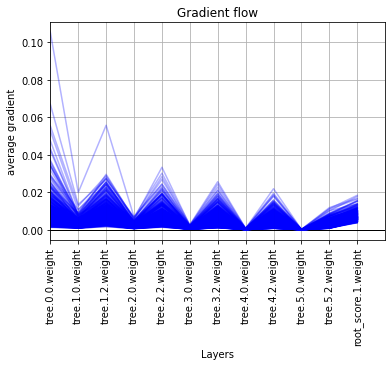

In [401]:
eps = 1e-12
lambda_gp= 10
#noise_level = noise_decay_
discriminator_loss_array = []
noise_array = []
generator_loss_array_ = []
lr_array_generator=[]
lr_array_critic = []
for epoch in range(epochs):
    for i, real_images in tqdm(enumerate(train_loader)):
        mean_ = 0
        sigma_ = 1
        latent_space = np.random.normal(mean_, sigma_, (batch_size,1,10,10))
            #scores real
        discriminator_scores_reals = \
                discriminator_network_model(real_images.float().to(device))
        dicriminator_real_loss = criterion(discriminator_scores_reals,
                torch.empty_like(discriminator_scores_reals).uniform_(0.8, 0.9).to(device))
            #scores fake  
        discriminator_scores_fakes = \
                discriminator_network_model(generator_network_model(latent_space).detach())
        discriminator_fake_loss = criterion(discriminator_scores_fakes,
                torch.empty_like(discriminator_scores_fakes).uniform_(0.0, 0.1).to(device))
        
        total_discriminator_loss = discriminator_fake_loss + dicriminator_real_loss
        optimizer_critic.zero_grad()
        total_discriminator_loss.backward()
        optimizer_critic.step()
        discriminator_loss_array.append(total_discriminator_loss.mean().item())
        
        
        if i % t_critic == 0:
            plot_grad_flow(discriminator_network_model.named_parameters())
            mean_ = 0
            sigma_ = 1
            latent_space = np.random.normal(mean_, sigma_, (batch_size,1,10,10))
            D_out = discriminator_network_model(generator_network_model(latent_space))
            generator_loss = criterion(D_out,
                    torch.ones_like(D_out).float().to(device))
            optimizer_generator.zero_grad()
            generator_loss.backward(retain_graph=True)
            optimizer_generator.step()
            generator_loss_array_.append(generator_loss.mean().item())
    decay_gauss_std(discriminator_network_model)
    lr_array_generator.append(optimizer_generator.param_groups[0]["lr"])
    lr_array_critic.append(optimizer_critic.param_groups[0]["lr"])

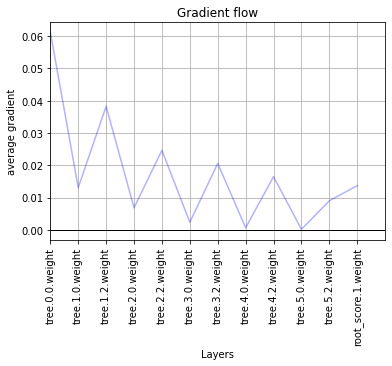

In [402]:
plot_grad_flow(discriminator_network_model.named_parameters())

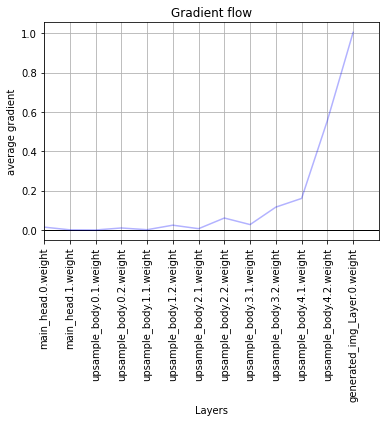

In [403]:
plot_grad_flow(generator_network_model.named_parameters())

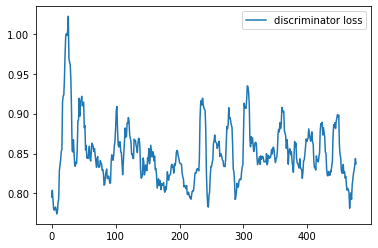

In [404]:
discriminator_loss_array
from scipy.ndimage.filters import uniform_filter1d
from matplotlib import pyplot as plt
arr = uniform_filter1d(discriminator_loss_array, size=10)
a=[]
y=[]
for i, e in enumerate(arr):
    y.append(i)
    a.append(e)
plt.plot(y, a,label='discriminator loss')
plt.legend()
plt.show()

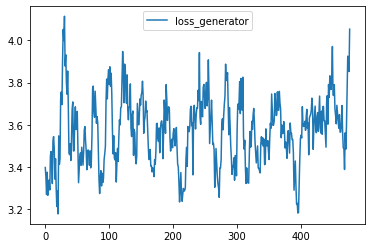

In [405]:
generator_loss_array_
arr = uniform_filter1d(generator_loss_array_, size=10)
c=[]
y=[]
for i, e in enumerate(arr):
    y.append(i)
    c.append(e)


plt.plot(y, c,label='loss_generator')
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


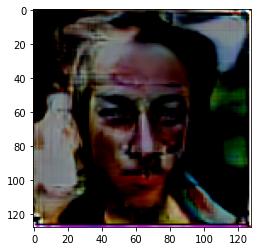

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


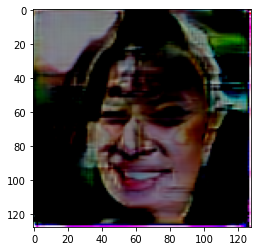

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


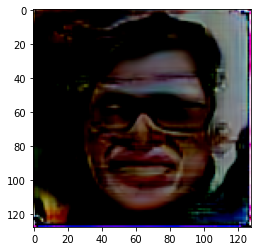

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


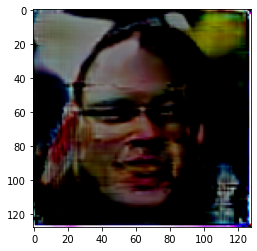

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


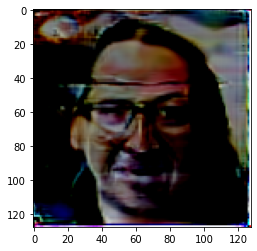

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


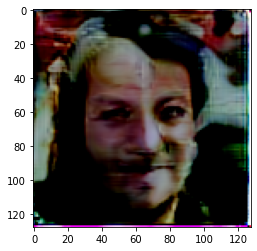

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


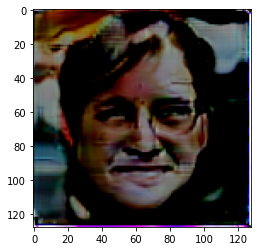

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


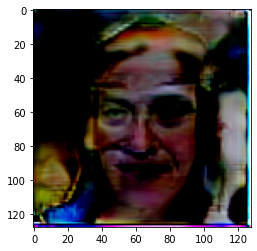

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


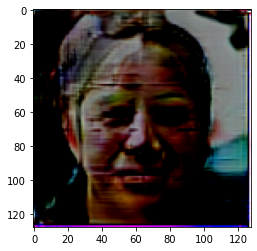

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


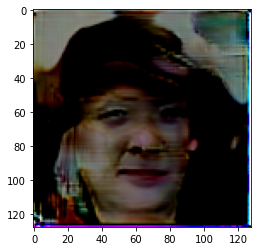

In [26]:
for i in range(10):
    mean_ = 0
    sigma_ = 1
    l_ = np.random.normal(mean_, sigma_, (1,1,10,10))
    with torch.no_grad():
        fake = generator_network_model(l_)
    fake = fake.detach().cpu().numpy() #create fake sample
    fake_ = np.squeeze(fake)
    fake_ = np.transpose(fake_, (2, 1, 0))
    plt.imshow(fake_)
    plt.show()

In [408]:
save_models(generator_network_model, discriminator_network_model)

In [18]:
load_models(generator_network_model, discriminator_network_model)

In [ ]:
plt.imshow(fake_)